In [29]:
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from scipy.optimize import fmin_l_bfgs_b
import keras.backend as K
from skimage.transform import resize

import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [30]:
def VGG16_AvgPool(shape):
  '''
    Return VGG16 network with MaxPool layers replaced with Average Pooling
    Params -
      shape -> shape of the input to the VGG network
  '''
  vgg = VGG16(input_shape = shape, weights = 'imagenet', include_top = False)
  i = vgg.input
  x = i
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      x = AveragePooling2D()(x)
    else:
      x = layer(x)
  return Model(i,x)

In [31]:
def VGG16_AvgPool_CutOff(shape, num_convs):
  '''
  Return VGG16 network with MaxPool layers replaced with Average Pooling and having desired number of Convolutional layers
    Params -
      shape -> shape of the input to the VGG network
      num_convs -> no of convolutional layers
  '''
  if num_convs < 1 or num_convs>=14 :
    print("No of conv layers required should be in range [1,13]")
    return None

  n = 0;
  vgg = VGG16_AvgPool(shape)
  output = None
  for layer in vgg.layers:
    if layer.__class__ == Conv2D:
      n += 1
    if n >= num_convs:
      output = layer.output
      break
  return Model(vgg.input, output)

In [32]:
def unpreprocess(img):
  '''
    Undoes keras preprocess function
  '''
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img

In [33]:
def scale_img(x):
  '''
    Normalize X = X - min(X) / max(X)
  '''
  x = x - x.min()
  x = x / x.max()
  return x

In [34]:
def gram_matrix(img):
  '''
    Return gram matrix for img
    Params -
      img -> vector for which gram matrix is to be calculated
  '''
  # convert input img dimension to (C,H*W)
  X = K.batch_flatten(K.permute_dimensions(img, (2,0,1)))
  # Gram Matrix = X.X^T/ N
  G = K.dot(X,K.transpose(X)) / img.get_shape().num_elements()
  return G

In [35]:
def calc_style_loss(img1,img2):
  '''
    Returns style loss between two images (img1, img2)
  '''
  return K.mean(K.square(gram_matrix(img1) - gram_matrix(img2)))

In [36]:
def minimize(func, epochs, batch_shape):
  '''
    Minimizes loss using the BFGS optimization algorithm
    Params -
      func - function to calculate loss
      epochs - number of epochs of optimization algorithm
      batch_shape - batch shape of input images
  '''
  losses = []
  x = np.random.randn(np.prod(batch_shape))
  for i in range(epochs):
    x, l, _ = fmin_l_bfgs_b(
        func = func,
        x0 = x,
        maxfun = 20
    )
    losses.append(l)
    np.clip(x,-127,127)
    print(f"iteration : {i}, loss : {l}")
  plt.plot(losses)
  plt.show()
  newimg = x.reshape(*batch_shape)
  final_img = unpreprocess(newimg)
  return final_img[0]

In [37]:
def show_img(img):
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [38]:
def load_and_preprocess_img(path, shape = None):
  '''
    load image at specified path and applies vgg preprocess input function to it
    Params -
      path -> path of the image to load
      shape -> desired shape for the loaded image (default value = None)
  '''
  img = image.load_img(path, target_size=shape)
  show_img(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  x = preprocess_input(x)
  return x

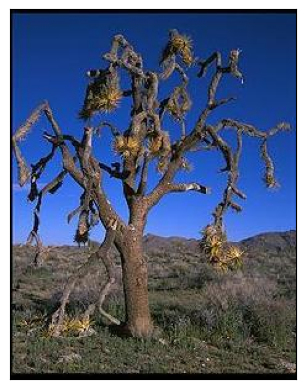

In [39]:
# Image of a joshua tree from Caltach-101 dataset
content_img = load_and_preprocess_img("/content/image_0001.jpg")

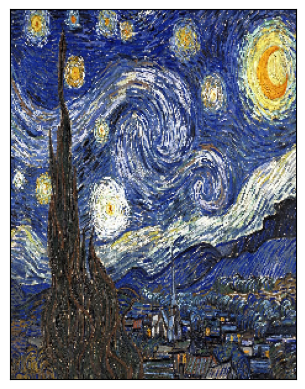

In [40]:
h,w = content_img.shape[1:3]
# Image of painting the starry night by Vincent van Gogh
style_img = load_and_preprocess_img("/content/StarryNight.jpg", (h,w)) # content and style image have same dimensions

In [41]:
batch_shape = content_img.shape
shape = content_img.shape[1:]
vgg = VGG16_AvgPool(shape) # VGG Network with input size = shape
vgg.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, 300, 232, 3), dtype=float32)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        multiple                     0         ['input_2[0][0]']             
                                                                                                  
 block1_conv1 (Conv2D)       (None, 300, 232, 64)         1792      ['input_2[1][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 300, 232, 64)         36928     ['block1_conv1[1][0]']        
                                                                                                  
 average_pooling2d_5 (Avera  (None, 150, 116, 64)         0         ['block1_conv2[1][0]']        
 gePooling2D)                                                                               

In [42]:
content_model = Model(vgg.input, vgg.layers[13].get_output_at(0)) # content model is VGG with cutoff after 13th layer
content_model.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, 300, 232, 3), dtype=float32)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 232, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 232, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 116, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 116, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 116, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 58, 128)       0   

In [43]:
content_target = K.variable(content_model.predict(content_img)) # output of the vgg network, when content image is fed

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [44]:
style_conv_outputs = [
    layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')
] # stores first convolution layer of each conv block inside vgg network
style_model = Model(vgg.input, style_conv_outputs) # style_model takes input of the type vgg.input and outputs a list
# of tensors which are output of the layers defined in the list "style_conv_outputs"
style_layer_outputs = [ K.variable(y) for y in style_model.predict(style_img)] # list of outputs

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: Tensor("input_2:0", shape=(None, 300, 232, 3), dtype=float32)


In [45]:
style_weights = [0.2,0.4,0.3,0.5,0.2]

In [46]:
# Loss = content_loss + sumOf(w * style_losses)
loss = K.mean(K.square(content_model.output - content_target))
for w, actual, predicted in zip(style_weights, style_conv_outputs, style_layer_outputs):
  loss += w * calc_style_loss(actual[0], predicted[0])

In [47]:
grads = K.gradients(loss, vgg.input) # gradient of loss w.r.to input since, we want to optimize pixels of input
# image such that it has content similar to content image and style of style image
get_loss_and_grads = K.function(
    inputs = [vgg.input],
    outputs = [loss] + grads
) # keras function which returns loss and gradient, takes input of the type vvg.input and outputs a tensor of loss followed by gradients
def get_loss_and_grads_wrapper(x_vec):
  # wrapper function to calculate loss and gradients
  l,g = get_loss_and_grads(x_vec.reshape(*batch_shape))
  return l.astype(np.float64), g.flatten().astype(np.float64)

iteration : 0, loss : 7090.85205078125
iteration : 1, loss : 2474.09716796875
iteration : 2, loss : 1494.093505859375
iteration : 3, loss : 1061.16259765625
iteration : 4, loss : 842.6092529296875
iteration : 5, loss : 720.638427734375
iteration : 6, loss : 632.771484375
iteration : 7, loss : 575.161376953125
iteration : 8, loss : 535.0035400390625
iteration : 9, loss : 501.55572509765625
iteration : 10, loss : 473.3818054199219
iteration : 11, loss : 450.3652038574219
iteration : 12, loss : 431.8289489746094
iteration : 13, loss : 416.3586730957031
iteration : 14, loss : 401.43017578125
iteration : 15, loss : 388.08905029296875
iteration : 16, loss : 376.1297607421875
iteration : 17, loss : 365.4239196777344
iteration : 18, loss : 355.9701843261719
iteration : 19, loss : 347.35235595703125


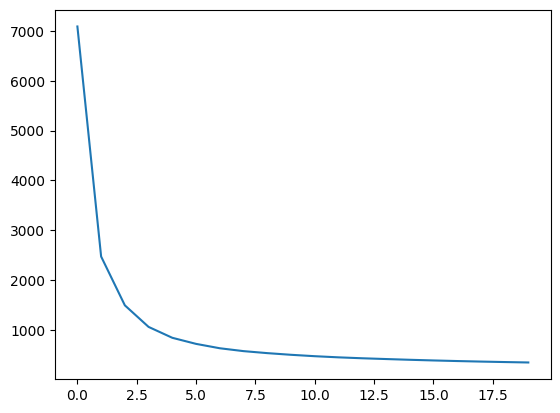

In [49]:
final_img = minimize(get_loss_and_grads_wrapper, 20, batch_shape)
# minimizing loss so, that optimized image has content of content_image and style similar to style_image

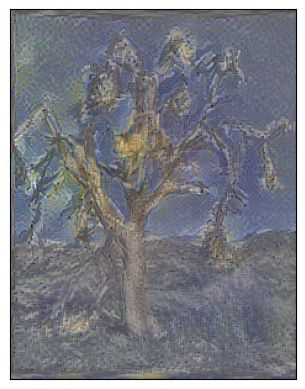

In [51]:
plt.imshow(scale_img(final_img))
plt.xticks([])
plt.yticks([])
plt.show()